In [2]:
import numpy as np
import tifffile
import matplotlib.pyplot as plt
import scipy.ndimage as nd
from astropy.convolution import convolve
import scipy.stats
from tqdm import tqdm
from skimage.restoration import denoise_tv_bregman
from numpy.linalg import norm
import scipy
import bm3d

In [3]:
filename_out_1 = "S1A_IW_SLC__1SDV_20170103T015004_20170103T015030_014661_017D92_6421_Orb_Stack(1).tif"
filename_out_2 = "S1A_IW_SLC__1SDV_20170103T015004_20170103T015030_014661_017D92_6421_Orb_Stack(2).tif"

image1 = tifffile.imread(filename_out_1)
image2 = tifffile.imread(filename_out_2)

#image reference
image_1 = image1[0,:,:] + 1j*image1[1,:,:]

#images recalées sur l'image reference 
image_2 = image1[2,:,:] + 1j*image1[3,:,:]
image_3 = image2[2,:,:] + 1j*image2[3,:,:]


In [4]:
sy2 = np.s_[800:1100] 
sx2 = np.s_[15400:15900]

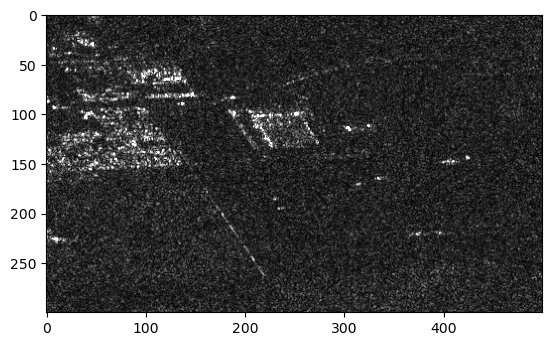

In [5]:
img1 = image_1[sy2, sx2]
plt.imshow(np.abs(img1),cmap="gray",vmax= 1/4* np.max(np.abs(img1)))
plt.show()

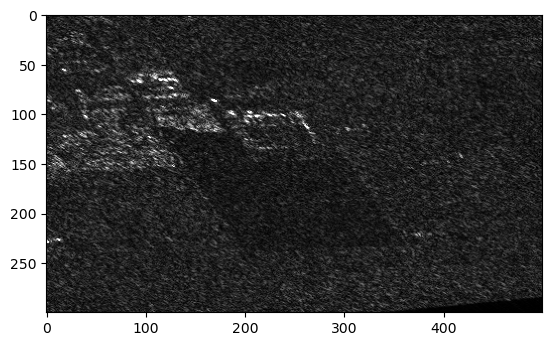

In [6]:
img2 = image_2[sy2, sx2]
plt.imshow(np.abs(img2),cmap="gray",vmax= 1/4* np.max(np.abs(img2)))
plt.show()

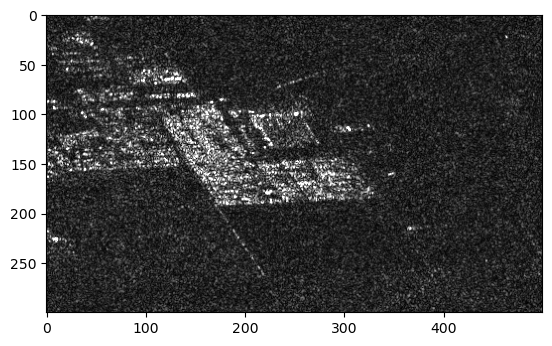

In [7]:
img3 = image_3[sy2, sx2]
plt.imshow(np.abs(img3),cmap="gray",vmax= 1/4* np.max(np.abs(img3)))
plt.show()

# Reactiv method for change detection

In [9]:
from scipy.special import gamma 
import numpy as np

def List2reactiv(List, L=1):
    """ Product output for REACTIV representation from a List of complex arrays
    Parameters
    ----------
    List : List of complex arrays
    L : float
        L is Equivalent Number of Looks. If data are SLC, then L=1. 
        if you do not specify L, it will be automatically estimated from the data
    Returns
    -------
    CV : float ndarray, between 0 and 1
        Coefficient of variation for the temporal axis. 
        Casted between 0, theoretical mean value, and 1, theoretical mean value+theoretical standard deviation 
    K : float ndarray, between 0 and 1
        Corresponds to the temporal fraction where maximal Amplitude is found during the observation period
    Amax : complex ndarray - not casted
        Corresponds to the array of maximal amplitude values reached during the observation period
    """
    Nt = len(List)  # temporal dimension

    Imax = List[0]

    # Compute Coefficient of Variation    
    M1 = np.zeros_like(Imax, dtype=np.complex128)
    M2 = np.zeros_like(Imax, dtype=np.complex128)
    Kmax = np.zeros_like(Imax, dtype=np.float64)
    Amax = np.zeros_like(Imax, dtype=np.complex128)

    k = 0
    for count, im in enumerate(List):
        M1 = M1 + im
        M2 = M2 + im**2
        k = k + 1
        Kmax = (np.abs(im) > np.abs(Imax)) * count + (np.abs(im) < np.abs(Imax)) * Kmax 
        Amax = np.maximum(Amax, im)

    M1 = M1 / Nt
    M2 = M2 / Nt
    K = Kmax / Nt
            
    # Compute the Coefficient of variation       
    R = np.sqrt(M2 - M1**2) / M1 
    R[M1 == 0] = 0  # Remove possible Nan Output when Signal is zero
    R[M1.real < 0] = 0
    
    # Theoretical estimation of mean and std of the Coefficient of variation for the given Equivalent Number of Looks     
    if L is None:
        gam = R.real.mean()
        L = ((0.991936 + 0.067646 * gam - 0.098888 * gam**2 - 0.048320 * gam**3) /
             (0.001224 - 0.034323 * gam + 4.305577 * gam**2 - 1.163498 * gam**3))
    
    Rmean = np.sqrt((L * gamma(L)**2 / (gamma(L + 0.5)**2)) - 1)  # theoretical mean value
    num = (L * gamma(L)**4 * (4 * (L**2) * gamma(L)**2 - 4 * L * gamma(L + 1/2)**2 - gamma(L + 1/2)**2))
    den = (gamma(L + 1/2)**4 * (L * gamma(L)**2 - gamma(L + 1/2)**2))
    Rstd = 1 / 4 * num / den / np.sqrt(Nt)  # theoretical standard deviation value
    Rmax = Rmean + Rstd

    # Recast Coefficient of Variation between 0 (mean value) and 1 (max value)    
    CV = (R.real - Rmean.real) / (Rmax.real - Rmean.real)
    CV = (CV >= 0) * CV
    CV = CV * (CV < 1) + (CV >= 1)
    return CV, K, Amax


In [10]:
List= [img1, img2, img3]

CV,K,Amax = List2reactiv(List,L=1)

print ("The coefficient of variation is:" ,CV) 

The coefficient of variation is: [[1.         1.         1.         ... 1.         1.         0.        ]
 [0.         0.         1.         ... 0.         0.         0.        ]
 [0.         1.         0.         ... 1.         1.         1.        ]
 ...
 [1.         0.         0.         ... 0.         0.36706855 1.        ]
 [1.         0.         1.         ... 1.         1.         1.        ]
 [1.         0.         0.         ... 0.         0.         0.        ]]


# Explanation of the coefficient of variation:

The CV array is scaled between 0 and 1. Each element in the array represents the coefficient of variation for the corresponding pixel or element in the images.

## Interpretation:
A value of 0 in the CV array indicates that the temporal variation for that pixel is at the theoretical mean value.
Values close to 1 indicate higher temporal variation compared to the mean.

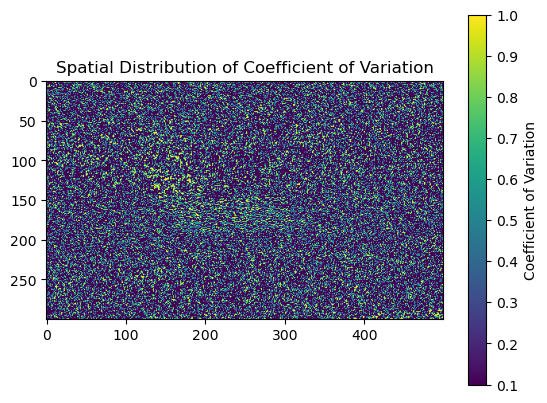

In [11]:
plt.imshow(CV, vmin=0.1, vmax=1)
plt.colorbar(label='Coefficient of Variation')
plt.title('Spatial Distribution of Coefficient of Variation')
plt.show()

Ici les resultats de la zone d'interet ne sont pas tres clairs parceque le code est implementé directement sur les images non traitée. On essaiera ultérieurement de les implémenter sur les images débruités

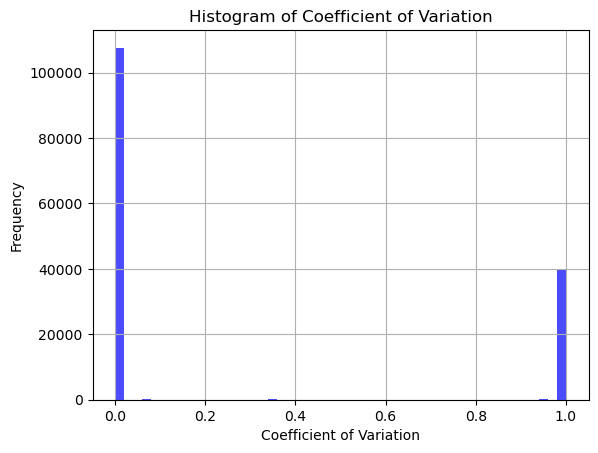

In [12]:
plt.hist(CV.flatten(), bins=50, color='blue', alpha=0.7)
plt.title('Histogram of Coefficient of Variation')
plt.xlabel('Coefficient of Variation')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()
